# Generador de numeros escritos a mano utilizando una GAN

In [91]:
#!conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia

In [92]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [93]:
torch.manual_seed(111)

In [94]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [95]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [96]:
# Se descarga el dataset de MNIST. Se agregan estos recursos ya que el dataset de MNIST ha cambiado de ubicación
from torchvision import datasets
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [97]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [98]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

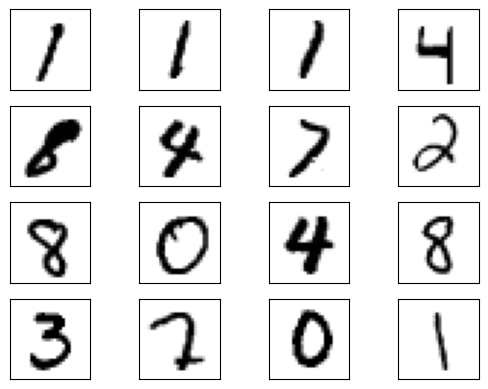

In [99]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])



## Discriminador

Ya que logramos cargar el dataset de MNIST, ahora vamos a crear el Discriminador de la GAN.

In [100]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
discriminator = Discriminator().to(device=device)

## Generador
Ahora producimos el Generador

In [101]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

Comenzamos con el entrenamiento

In [102]:
# Configuración de Hyperparametros
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()



optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [103]:
# Ciclos de entrenamiento
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5889772176742554
Epoch: 0 Loss G.: 0.4736277759075165
Epoch: 1 Loss D.: 0.07721339911222458
Epoch: 1 Loss G.: 4.602213382720947
Epoch: 2 Loss D.: 0.007678383961319923
Epoch: 2 Loss G.: 6.917222499847412
Epoch: 3 Loss D.: 0.012719925493001938
Epoch: 3 Loss G.: 7.036237716674805
Epoch: 4 Loss D.: 0.11879807710647583
Epoch: 4 Loss G.: 4.524302959442139
Epoch: 5 Loss D.: 0.08319099247455597
Epoch: 5 Loss G.: 4.9174089431762695
Epoch: 6 Loss D.: 0.039620425552129745
Epoch: 6 Loss G.: 3.2692949771881104
Epoch: 7 Loss D.: 0.25406038761138916
Epoch: 7 Loss G.: 2.745271921157837
Epoch: 8 Loss D.: 0.4595899283885956
Epoch: 8 Loss G.: 2.59075927734375
Epoch: 9 Loss D.: 0.4185664653778076
Epoch: 9 Loss G.: 1.5906319618225098
Epoch: 10 Loss D.: 0.2699463963508606
Epoch: 10 Loss G.: 1.7084954977035522
Epoch: 11 Loss D.: 0.3940170109272003
Epoch: 11 Loss G.: 1.2418653964996338
Epoch: 12 Loss D.: 0.31079554557800293
Epoch: 12 Loss G.: 1.5347294807434082
Epoch: 13 Loss D.: 0.4644604

Revisión del resultado

In [104]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

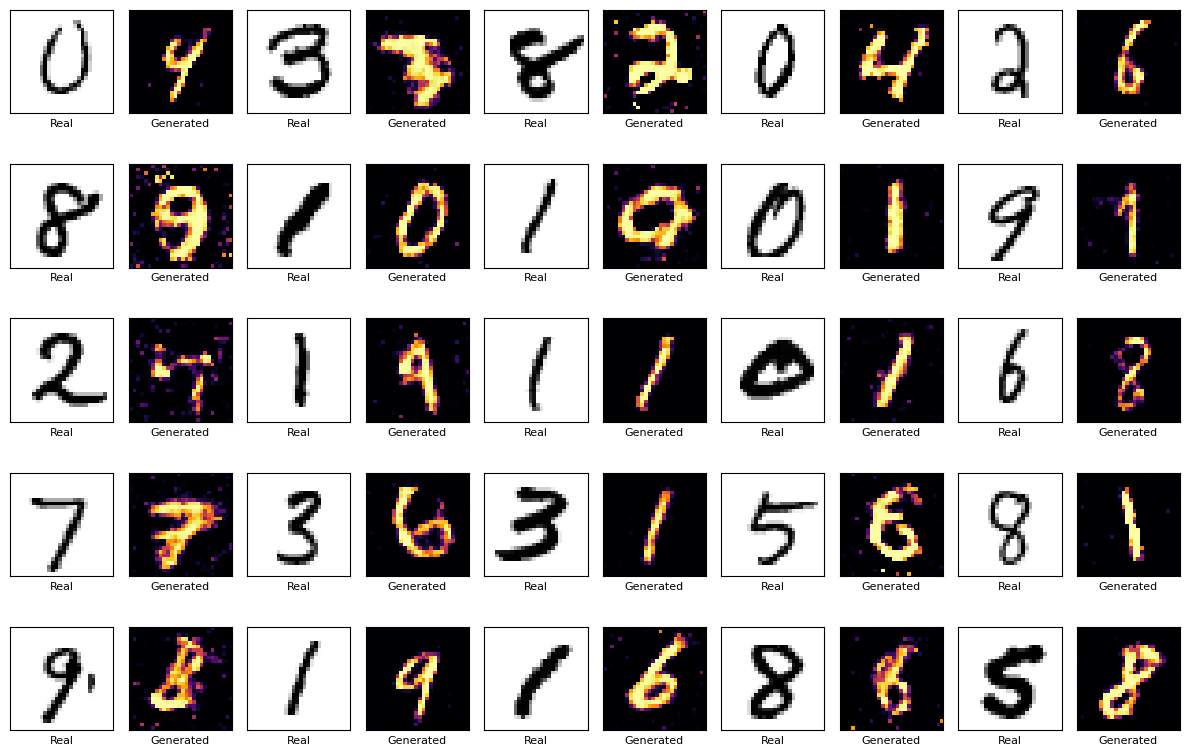

In [105]:
generated_samples = generated_samples.cpu().detach()
real_samples = real_samples.cpu().detach()


fig, axs = plt.subplots(5, 10, figsize=(12, 8))  # 6 rows and 12 columns (6 pairs of real and generated samples per row)

for i in range(5):
    for j in range(5):
        # Real sample on the left
        ax_real = axs[i, j * 2]
        ax_real.imshow(real_samples[i * 6 + j].reshape(28, 28), cmap="gray_r")
        ax_real.set_xticks([])
        ax_real.set_yticks([])
        ax_real.set_xlabel('Real', fontsize=8)

        # Generated sample on the right
        ax_gen = axs[i, j * 2 + 1]
        ax_gen.imshow(generated_samples[i * 6 + j].reshape(28, 28), cmap="inferno")
        ax_gen.set_xticks([])
        ax_gen.set_yticks([])
        ax_gen.set_xlabel('Generated', fontsize=8)

plt.tight_layout()
plt.show()
    
    